In [56]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

means_data = pd.read_csv("Data/mean_matrix.csv")

wages = means_data[means_data["alder"] <= 61]["hourly_salary_Mean"].to_numpy()
hours = means_data[means_data["alder"] <= 61]["yearly_hours_Mean"].to_numpy() / 1924


In [57]:
def sum_hours(t, k0, hours, delta):
    # total = np.sum(hours[:70])
    total = k0
    for i in range(t):
        total += (1 - delta) ** i * hours[t - i]
    return total

def objective_function(params, wages, hours):
    k0, beta1, beta2, delta = params
    total_error = 0
    for t in range(len(wages)):
        error = (
            np.log(wages[t])
            - beta1 * (sum_hours(t, k0, hours, delta))
            - beta2 * t**2
        )
        total_error += error ** 2
    return total_error

initial_guess = [200, 0.02, -0.001, 0.01]
bounds = [(0.001, 300), (0, 200), (-20, 0), (0, 0.10)]

def random_initial_guess(bounds):
    # np.random.seed(1)
    return [np.random.uniform(low, high) for low, high in bounds]

# initial_guess = random_initial_guess(bounds)


result = minimize(
    objective_function,
    x0=initial_guess,
    args=(wages, hours),
    method="Nelder-Mead",
    bounds=bounds,
    tol=1e-12,
    options={
        "maxiter": 100000,  # Maximum iterations
        "xatol": 1e-12,
        "fatol": 1e-12, 
        "disp": True
    }
)


estimated_params = result.x
k0_est, beta1_est, beta2_est, delta_est = estimated_params

results_dict = {
    "Parameter": ["k0", "beta1", "beta2", "delta"],
    "Estimated Value": [k0_est, beta1_est, beta2_est, delta_est],
}

results_df = pd.DataFrame(results_dict)

print(results_df)

print(result.fun)

Optimization terminated successfully.
         Current function value: 0.000572
         Iterations: 682
         Function evaluations: 1206
  Parameter  Estimated Value
0        k0       195.701266
1     beta1         0.027279
2     beta2        -0.000388
3     delta         0.028693
0.0005720501253452951


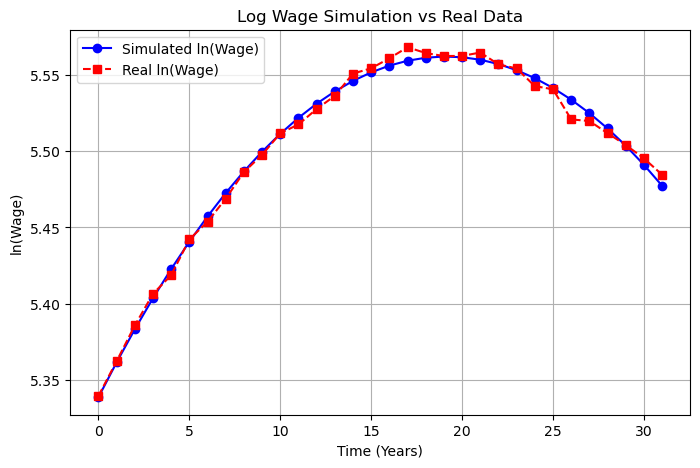

In [58]:
def simulate(params, wages, hours):
    k0, beta1, beta2, delta = params
    ln_wage = np.zeros(len(wages))
    for t in range(len(wages)):
        ln_wage[t] = (
            beta1 * (sum_hours(t, k0, hours, delta))
            + beta2 * t**2
        )

    return ln_wage


ln_wage = simulate(estimated_params, wages, hours)


import matplotlib.pyplot as plt

def plot_ln_wage(ln_wage, man_hourly_salary, title="Log Wage Simulation vs Real Data", 
                 xlabel="Time (Years)", ylabel="ln(Wage)"):
    plt.figure(figsize=(8, 5))
    
    # Convert real hourly salary to log scale for comparison
    ln_real_wage = np.log(man_hourly_salary)
    
    # Plot simulated ln_wage
    plt.plot(ln_wage, marker="o", linestyle="-", label="Simulated ln(Wage)", color='b')
    
    # Plot real ln(wage)
    plt.plot(ln_real_wage, marker="s", linestyle="--", label="Real ln(Wage)", color='r')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ln_wage(ln_wage, wages)

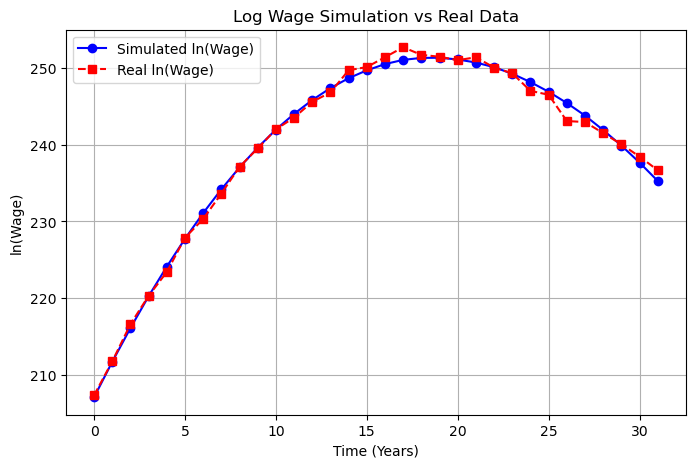

In [9]:
plot_ln_wage(np.exp(ln_wage), np.exp(wages))